In [1]:
!curl -X GET "http://localhost:9200/"

{"error":{"root_cause":[{"type":"security_exception","reason":"missing authentication credentials for REST request [/]","header":{"WWW-Authenticate":["Basic realm=\"security\", charset=\"UTF-8\"","ApiKey"]}}],"type":"security_exception","reason":"missing authentication credentials for REST request [/]","header":{"WWW-Authenticate":["Basic realm=\"security\", charset=\"UTF-8\"","ApiKey"]}},"status":401}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   405  100   405    0     0  57577      0 --:--:-- --:--:-- --:--:-- 67500


In [3]:
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch("http://localhost:9200", basic_auth=("elastic", "R5nRHqCLO7HQ9-8O5P*n"))
client_info = es.info()
pprint(client_info.body)

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'UfBw1_LjTRmCyG3m5Qb02A',
 'name': 'INT-LDSQUYH-LAP',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-02-05T22:10:57.067596412Z',
             'build_flavor': 'default',
             'build_hash': '747663ddda3421467150de0e4301e8d4bc636b0c',
             'build_snapshot': False,
             'build_type': 'zip',
             'lucene_version': '9.12.0',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.17.2'}}


In [4]:
es.ping()

True

In [6]:
# Lấy danh sách tất cả các indices
indices = es.indices.get_alias().keys()

# In ra danh sách indices
print("Danh sách các indices:")
for index in indices:
    print(index)


Danh sách các indices:
other_common_data_types_index
index_1
.security-7
index_2
geo_point_index
nested_object_index
geo_shape_index
my_index
object_index
binary_index
flattened_object_index
my_documents


C:\Users\Admin\AppData\Local\Temp\ipykernel_16772\186389059.py:2: ElasticsearchWarning: this request accesses system indices: [.security-7], but in a future major version, direct access to system indices will be prevented by default
  indices = es.indices.get_alias().keys()


# 1. Create index

In [11]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [13]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index="my_index",
    settings={
        "index":{
            "number_of_shards": 3,
            "number_of_replicas": 2
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

# 2. Insert documents into the index (my_index)

In [14]:
document = {
    'title': "title",
    'text': 'text',
    'created_on': '2024-09-22'
}
response = es.index(index='my_index', body=document)
response

ObjectApiResponse({'_index': 'my_index', '_id': 'F_krApUBF5u38qzqP0zL', '_version': 1, 'result': 'created', '_shards': {'total': 3, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [15]:
print(response["_id"])

F_krApUBF5u38qzqP0zL


In [16]:
print(response["_index"])

my_index


In [17]:
response = es.get(index="my_index", id='F_krApUBF5u38qzqP0zL')
print(response['_source'])


{'title': 'title', 'text': 'text', 'created_on': '2024-09-22'}


## 2.1 Insert multiple documents

Mỗi documents thì có 1 _id riêng để truy cập

In [19]:
import json

dummy_data = json.load(open("dummy_data.json"))
dummy_data

[{'title': 'sample title 1',
  'text': 'this is the first sample document text.',
  'created_on': '2024-09-22'},
 {'title': 'sample title 2',
  'text': 'this is the second sample document text.',
  'created_on': '2024-09-22'},
 {'title': 'sample title 3',
  'text': 'this is the third sample document text.',
  'created_on': '2024-09-22'}]

In [20]:
def insert_document(document):
    response = es.index(index="my_index", body=document)
    return response

def print_info(response):
    print(f"{response['_id']} -> document_id: {response['_id']} is '{response['result']}' and is split in do {response['_shards']['total']} shards.")

for document in dummy_data:
    response = insert_document(document)
    print_info(response)

GPksApUBF5u38qzqoUx_ -> document_id: GPksApUBF5u38qzqoUx_ is 'created' and is split in do 3 shards.
GfksApUBF5u38qzqo0w3 -> document_id: GfksApUBF5u38qzqo0w3 is 'created' and is split in do 3 shards.
GvksApUBF5u38qzqpEy3 -> document_id: GvksApUBF5u38qzqpEy3 is 'created' and is split in do 3 shards.


In [24]:
response = es.get(index="my_index", id='GfksApUBF5u38qzqo0w3')
print(response['_source'])

{'title': 'sample title 2', 'text': 'this is the second sample document text.', 'created_on': '2024-09-22'}


# 3. mapping

In [25]:
from pprint import pprint

index_mapping = es.indices.get_mapping(index='my_index')
pprint(index_mapping['my_index']['mappings']['properties'])

{'created_on': {'type': 'date'},
 'text': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
          'type': 'text'},
 'title': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
           'type': 'text'}}


## 3.1 Manual mapping

In [27]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index="my_index")

mapping = {
    'properties': {
        'create_on': {'type': 'date'},
        'text': {
            'type': 'text',
            'fields': {
                'keyword': {
                    'type': 'keyword',
                    'ignore_above': 256
                }
            }
        },
        'title': {
            'type': 'text',
            'fields': {
                'keyword': {
                    'type': 'keyword',
                    'ignore_above': 256
                }
            }
        }
    }
}

es.indices.put_mapping(index="my_index", body=mapping)
index_mapping = es.indices.get_mapping(index="my_index")
pprint(index_mapping['my_index']['mappings']['properties'])

{'create_on': {'type': 'date'},
 'text': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
          'type': 'text'},
 'title': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
           'type': 'text'}}


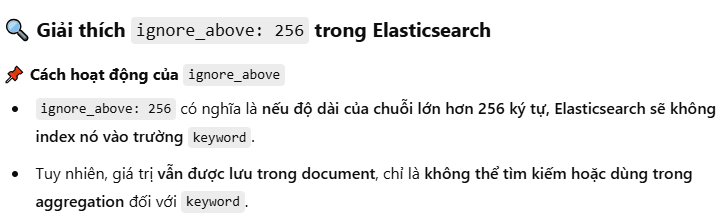

# 4. Field data types

In [28]:
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch("http://localhost:9200", basic_auth=("elastic", "R5nRHqCLO7HQ9-8O5P*n"))
client_info = es.info()
pprint(client_info.body)

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'UfBw1_LjTRmCyG3m5Qb02A',
 'name': 'INT-LDSQUYH-LAP',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-02-05T22:10:57.067596412Z',
             'build_flavor': 'default',
             'build_hash': '747663ddda3421467150de0e4301e8d4bc636b0c',
             'build_snapshot': False,
             'build_type': 'zip',
             'lucene_version': '9.12.0',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.17.2'}}


In [74]:
# Lấy danh sách tất cả các indices
indices = es.indices.get_alias().keys()

# In ra danh sách indices
print("Danh sách các indices:")
for index in indices:
    print(index)


Danh sách các indices:
.security-7
my_index
my_documents


C:\Users\Admin\AppData\Local\Temp\ipykernel_8256\186389059.py:2: ElasticsearchWarning: this request accesses system indices: [.security-7], but in a future major version, direct access to system indices will be prevented by default
  indices = es.indices.get_alias().keys()


In [78]:
es.indices.delete(index='binary_index', ignore_unavailable=True)
es.indices.create(
    index= 'binary_index',
    mappings={
        "properties":{
            "image_data": {
                "type": "binary"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'binary_index'})

In [82]:
# Lấy danh sách tất cả các indices
indices = es.indices.get_alias().keys()

# In ra danh sách indices
print("Danh sách các indices:")
for index in indices:
    print(index)

Danh sách các indices:
.security-7
my_index
binary_index
my_documents


C:\Users\Admin\AppData\Local\Temp\ipykernel_8256\128042551.py:2: ElasticsearchWarning: this request accesses system indices: [.security-7], but in a future major version, direct access to system indices will be prevented by default
  indices = es.indices.get_alias().keys()


## 4.1 Binary type

In [88]:
import base64

img_path = r'D:\.thuctap\tma\code\picture.png'
with open(img_path, 'rb') as img:
    image_bytes = img.read()
    image_base64 = base64.b64encode(image_bytes).decode("utf-8")

print(len(image_base64))
print(image_base64[:110])

221100
iVBORw0KGgoAAAANSUhEUgAABGQAAAKGCAYAAAAMKE12AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqG


In [84]:
document = {
    "image_data": image_base64
}
response = es.index(index='binary_index', body=document)
response

ObjectApiResponse({'_index': 'binary_index', '_id': 'yYPB_pQBpb_bR65mSyk2', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [29]:
doc = es.get(index="binary_index", id="yYPB_pQBpb_bR65mSyk2")
doc['_source']

{'image_data': 'iVBORw0KGgoAAAANSUhEUgAABGQAAAKGCAYAAAAMKE12AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7L0HgF1lmf//3D69ZJKZ9EnvjUACoYcuIKCioLLLKmBjrav83LX8FXV11XXVlXWxrrp2XFFBRVSQFnonhPSeTO/t1v/zfc59Z24uM5mZZGZyJ/l+Jm/OOe95+zn3nvN+7/O+ry+lCDmuaeuKSyx+6GUO+H1SWhhMH40MLR1xSSSHejvdLx9bfpPIf26Rz52b9iJD5BG57Y2PyNpffljWpH3IicO+O94jH/n5nvRRH2d85Hdy89r0ASGEEEIIISTnoSBzAhCLJ6WtK5E+6iMS8kthXiB9dHR0dCekJ5ZMHx2eh/5lvrzvdyKzP3Sf/Opt09O+hBBCCCGEEELIiQMFmROE/qxkQH7YL/mRoxNlunoS0hUdmhhDCCGEEEIIIYQQEX96S45zCgYQXSCkwLrlSEFcijGEEEIIIYQQQsjwoIXMCQSGFA0kvmBOGVjLhEND0+iimhaEmKHPGUMIIYQQQgghhBAHBZkTDIgoGGI0EBBmwkGfBIN+29d/BnQXiC/xeFKi8RSFGEIIIYQQQggh5CigIHMCMpgoQwghhBBCCCGEkNGFc8icgGBo0kitrkQIIYQQQgghhJDhQwuZExgMO+rsSfS7+hIhhBBCCCGEEEJGDwoyRGLxpHTHkhRmCCGEEEIIIYSQMYKCDOkF8/RCnIknUuaSemvw7iCEEEIIIYQQQkYeCjKEEEIIIYQQQgghYwwn9SWEEEIIIYQQQggZYyjIEEIIIYQQQgghhIwxFGQIIYQQQgghhBBCxhgKMoQQQgghhBBCCCFjDAUZQgghhBBCCCGEkDHGt2vPLq6yRAghhBBCCCGEEDKG+EpLSynIEEIIIYQQQgghhIwhHLJECCGEEEII

## 4.2 Other Type

In [104]:
es.indices.delete(index='other_common_data_types_index', ignore_unavailable=True)
es.indices.create(
    index='other_common_data_types_index',
    mappings={
        "properties":{
            "book_reference": {
                'type': "keyword"
            },
            "price": {
                "type": "float"
            },
            "publish_date": {
                "type": "date"
            },
            "is_available": {
                "type": "boolean"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'other_common_data_types_index'})

In [107]:
document = {
    "book_reference": "113-856987",
    "price": 85.6,
    "publish_date": "2021-06-30",
    "is_available": True
}
response = es.index(index='other_common_data_types_index', body=document)
response

ObjectApiResponse({'_index': 'other_common_data_types_index', '_id': 'zIPR_pQBpb_bR65mdSkH', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [109]:
doc = es.get(index="other_common_data_types_index", id="zIPR_pQBpb_bR65mdSkH")
doc['_source']

{'book_reference': '113-856987',
 'price': 85.6,
 'publish_date': '2021-06-30',
 'is_available': True}

In [34]:
index_mapping = es.indices.get_mapping(index="other_common_data_types_index")
pprint(index_mapping['other_common_data_types_index']['mappings']['properties'])

{'book_reference': {'type': 'keyword'},
 'is_available': {'type': 'boolean'},
 'price': {'type': 'float'},
 'publish_date': {'type': 'date'}}


## 4.3 Non-Flattened object type

In [120]:
es.indices.delete(index='object_index', ignore_unavailable=True)
es.indices.create(
    index="object_index",
    mappings={
        "properties": {
            "author": {
                "properties":{
                    "first_name": {
                        "type": "text"
                    },
                    "last_name": {
                        "type": "text"
                    }
                }
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'object_index'})

In [122]:
document = {
    "author": {
        "first_name": "Lê",
        "last_name": "Đào Sỷ Quỳnh"
    }
}
response = es.index(index="object_index", body=document)
response

ObjectApiResponse({'_index': 'object_index', '_id': 'z4Pm_pQBpb_bR65m5ynX', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [124]:
doc = es.get(index='object_index', id='z4Pm_pQBpb_bR65m5ynX')
doc['_source']

{'author': {'first_name': 'Lê', 'last_name': 'Đào Sỷ Quỳnh'}}

In [149]:
index_mapping = es.indices.get_mapping(index="object_index")
pprint(index_mapping['object_index']['mappings']['properties'])

{'author': {'properties': {'first_name': {'type': 'text'},
                           'last_name': {'type': 'text'}}}}


## 4.4 Flattened object type

In [111]:
es.indices.delete(index='flattened_object_index', ignore_unavailable=True)
es.indices.create(
    index="flattened_object_index",
    mappings={
        "properties": {
            "author": {
                "type": "flattened"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'flattened_object_index'})

In [112]:
document = {
    "author": {
        "first_name": "Lê",
        "last_name": "Đào Sỷ Quỳnh"
    }
}
response = es.index(index="flattened_object_index", body=document)
response

ObjectApiResponse({'_index': 'flattened_object_index', '_id': 'zYPi_pQBpb_bR65mnik5', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [115]:
doc = es.get(index='flattened_object_index', id='zYPi_pQBpb_bR65mnik5')
doc['_source']

{'author': {'first_name': 'Lê', 'last_name': 'Đào Sỷ Quỳnh'}}

In [125]:
index_mapping = es.indices.get_mapping(index="flattened_object_index")
pprint(index_mapping['flattened_object_index']['mappings']['properties'])

{'author': {'type': 'flattened'}}


## 4.5 Nested object

In [44]:
es.indices.delete(index='nested_object_index', ignore_unavailable=True)
es.indices.create(
    index="nested_object_index",
    mappings={
        "properties": {
            "user": {
                "type": "nested"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'nested_object_index'})

In [45]:
document = [
    {
        "first": "Lê",
        "last": "Đào Sỷ Quỳnh"
    },
    {
        "first": "Phạm",
        "last": "Thị Như Ý"
    }
]
response = es.index(index="nested_object_index", body={"user": document})
response

ObjectApiResponse({'_index': 'nested_object_index', '_id': '-8y5DpUBQTAtGshzLyHk', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [47]:
doc = es.get(index='nested_object_index', id='-8y5DpUBQTAtGshzLyHk')
doc['_source']

{'user': [{'first': 'Lê', 'last': 'Đào Sỷ Quỳnh'},
  {'first': 'Phạm', 'last': 'Thị Như Ý'}]}

In [48]:
index_mapping = es.indices.get_mapping(index="nested_object_index")
pprint(index_mapping['nested_object_index']['mappings']['properties'])

{'user': {'properties': {'first': {'fields': {'keyword': {'ignore_above': 256,
                                                          'type': 'keyword'}},
                                   'type': 'text'},
                         'last': {'fields': {'keyword': {'ignore_above': 256,
                                                         'type': 'keyword'}},
                                  'type': 'text'}},
          'type': 'nested'}}


## 4.6 Spatial data types

### 4.6.1 Geo point

In [ ]:
es.indices.delete(index='geo_point_index', ignore_unavailable=True)
es.indices.create(
    index='geo_point_index', 
    mappings={
        "properties": {"location": {"type": "geo_point"}}})

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'geo_point_index'})

In [54]:
document = {
    "text": "Geopoint as an object using GeoJSON format",
    "location": {
        "type": "Point",
        "coordinates":[
            71.12,
            41.12
        ]
    }
}
response = es.index(index='geo_point_index', body=document)
response

ObjectApiResponse({'_index': 'geo_point_index', '_id': 'H_lkApUBF5u38qzq2Ewi', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1})

In [56]:
es.get(index='geo_point_index', id='H_lkApUBF5u38qzq2Ewi')['_source']

{'text': 'Geopoint as an object using GeoJSON format',
 'location': {'type': 'Point', 'coordinates': [71.12, 41.12]}}

In [57]:
index_mapping = es.indices.get_mapping(index="geo_point_index")
pprint(index_mapping['geo_point_index']['mappings']['properties'])

{'location': {'type': 'geo_point'},
 'text': {'fields': {'keyword': {'ignore_above': 256, 'type': 'keyword'}},
          'type': 'text'}}


### 4.6.2 Geo shape

In [64]:
es.indices.delete(index='geo_shape_index', ignore_unavailable=True)
es.indices.create(index='geo_shape_index', 
                  mappings={
                      "properties": {
                          "location_ne": {
                              "type": "geo_shape"}}})

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'geo_shape_index'})

In [70]:
document_1 = {
    'location_ne': {
        "type": "LineString",
        "coordinates": [
            [
                -77.26555,
                38.122552
            ],
            [
                -77.021211,
                38.8989898
            ]
        ]
    }
}
document_2 = {
    'location_ne': {
        "type": "Polygon",
        "coordinates": [
            [
               [100,0],
                [101,0],
                [101,1],
                [100,1],
                [100,0]
            ],
            [
                [100.2,0.2],
                [100.8,0.2],
                [100.8,0.8],
                [100.2,0.8],
                [100.2,0.2]
            ]
        ]
    }
}
es.index(index='geo_shape_index', body=document_1)
es.index(index='geo_shape_index', body=document_2)

ObjectApiResponse({'_index': 'geo_shape_index', '_id': 'LfltApUBF5u38qzqIkxB', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 8, '_primary_term': 1})

In [72]:
es.get(index='geo_shape_index', id='LfltApUBF5u38qzqIkxB')['_source']

{'location_ne': {'type': 'Polygon',
  'coordinates': [[[100, 0], [101, 0], [101, 1], [100, 1], [100, 0]],
   [[100.2, 0.2], [100.8, 0.2], [100.8, 0.8], [100.2, 0.8], [100.2, 0.2]]]}}

In [73]:
index_mapping = es.indices.get_mapping(index="geo_shape_index")
pprint(index_mapping['geo_shape_index']['mappings']['properties'])

{'location_ne': {'type': 'geo_shape'}}


# 5. Delete/Get documents

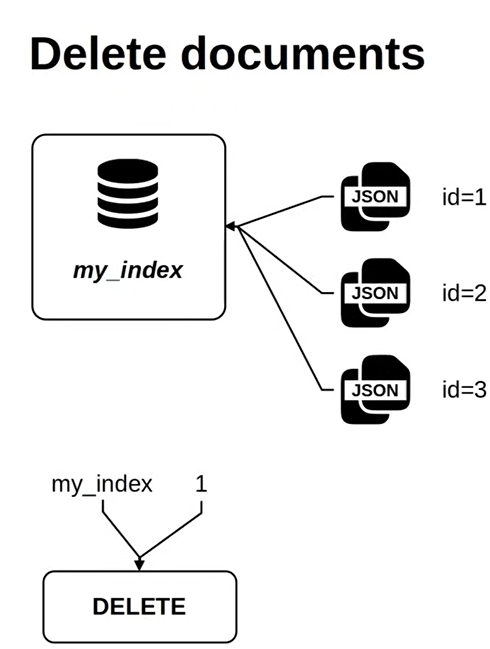

In [74]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [77]:
import json
from tqdm import tqdm

document_ids = []
dummy_data = json.load(open("dummy_data.json"))
for document in tqdm(dummy_data, total=len(dummy_data)):
    response = es.index(index='my_index', body=document)
    document_ids.append(response['_id'])

100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


In [78]:
document_ids

['Lvl5ApUBF5u38qzq5Ey2', 'L_l5ApUBF5u38qzq5kys', 'MPl5ApUBF5u38qzq50xt']

In [89]:
es.get(index='my_index', id='Lvl5ApUBF5u38qzq5Ey2')['_source']

{'title': 'sample title 1',
 'text': 'this is the first sample document text.',
 'created_on': '2024-09-22'}

In [90]:
#Delete operation
response = es.delete(index='my_index', id='Lvl5ApUBF5u38qzq5Ey2')

In [ ]:
# es.get(index='my_index', id='Lvl5ApUBF5u38qzq5Ey2')['_source']

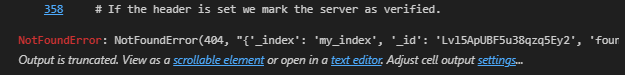

### Count

In [54]:
import json
from tqdm import tqdm

document_ids = []
dummy_data = json.load(open("dummy_data.json"))
for document in tqdm(dummy_data, total=len(dummy_data)):
    response = es.index(index='my_index', body=document)
    document_ids.append(response['_id'])
print(dummy_data)

100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

[{'title': 'sample title 1', 'text': 'this is the first sample document text.', 'created_on': '2024-09-22'}, {'title': 'sample title 2', 'text': 'this is the second sample document text.', 'created_on': '2024-09-20'}, {'title': 'sample title 3', 'text': 'this is the third sample document text.', 'created_on': '2024-09-10'}]


In [55]:
es.count(index='my_index')['count']

6

In [56]:
querry = {
    "range": {
        "created_on": {
            "gte": "2024-09-22",
            'lte': "2024-09-24",
            "format": "yyyy-MM-dd"
        }
    }
}
response = es.count(index='my_index', query=querry)
print("The number of documents in the index is: ", response['count'])


The number of documents in the index is:  2


In [57]:
response

ObjectApiResponse({'count': 2, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

# 6. API 

## 6.1 Exists 

In [58]:
#Check index existence
response = es.indices.exists(index='nested_object_index')
response.body

True

In [59]:
#Check document existence
response = es.exists(index='my_index', id=document_ids[2])
response.body

True

## 6.2 Update

In [129]:
response = es.update(
    index="my_index",
    id=document_ids[0],
    script={
        "source": "ctx._source.title=params.title_ne",
        "params": {
            "title_ne": "new title neee"
        }
    }
)
pprint(response.body)

{'_id': 'NPmQApUBF5u38qzqG0yv',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 13,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 5,
 'result': 'updated'}


In [130]:
response = es.get(index="my_index", id=document_ids[0])
pprint(response.body)

{'_id': 'NPmQApUBF5u38qzqG0yv',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 13,
 '_source': {'created_on': '2024-09-22',
             'text': 'this is the first sample document text.',
             'title': 'new title neee'},
 '_version': 5,
 'found': True}


## 6.3 Add new field

In [62]:
response = es.update(
    index="my_index",
    id=document_ids[0],
    script={
        # "source": "ctx._source.new_filed_ne = 'dummy_valueeee'",
        "source": "ctx._source.new_field2=params.new_field2",
        "params": {
            "new_field2": "heheheehehe"
        }
    }
)
pprint(response.body)

{'_id': '_My_DpUBQTAtGshzaSEu',
 '_index': 'my_index',
 '_primary_term': 2,
 '_seq_no': 7,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 3,
 'result': 'updated'}


In [63]:
response = es.get(index="my_index", id=document_ids[0])
pprint(response.body)

{'_id': '_My_DpUBQTAtGshzaSEu',
 '_index': 'my_index',
 '_primary_term': 2,
 '_seq_no': 7,
 '_source': {'created_on': '2024-09-22',
             'new_field2': 'heheheehehe',
             'new_filed_ne': 'dummy_valueeee',
             'text': 'this is the first sample document text.',
             'title': 'sample title 1'},
 '_version': 3,
 'found': True}


## 6.4 Remove a field

In [67]:
response = es.update(
    index="my_index",
    id = document_ids[0],
    script={
        "source": "ctx._source.remove('new_field2')"
    }
)
pprint(response.body)

{'_id': '_My_DpUBQTAtGshzaSEu',
 '_index': 'my_index',
 '_primary_term': 2,
 '_seq_no': 9,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 5,
 'result': 'updated'}


In [68]:
response = es.get(index="my_index", id=document_ids[0])
pprint(response.body)

{'_id': '_My_DpUBQTAtGshzaSEu',
 '_index': 'my_index',
 '_primary_term': 2,
 '_seq_no': 9,
 '_source': {'created_on': '2024-09-22',
             'text': 'this is the first sample document text.',
             'title': 'sample title 1'},
 '_version': 5,
 'found': True}


## 6.5 Bulk

### 6.5.1 Without bulk API

In [185]:
es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index="my_index")

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [186]:
# Index documents seqientially
import json

document_ids = []
dummy_data = json.load(open("dummy_data.json"))
for document in dummy_data:
    response = es.index(index='my_index', body=document)
    document_ids.append(response['_id'])

In [190]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[{'created_on': '2024-09-22',
  'text': 'this is the first sample document text.',
  'title': 'sample title 1'},
 {'created_on': '2024-09-20',
  'text': 'this is the second sample document text.',
  'title': 'sample title 2'},
 {'created_on': '2024-09-10',
  'text': 'this is the third sample document text.',
  'title': 'sample title 3'}]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


In [191]:
document_ids

['Q_kgA5UBF5u38qzq-0zL', 'RPkgA5UBF5u38qzq_Uwu', 'RfkgA5UBF5u38qzq_UyS']

In [197]:
# Update the first documents
from pprint import pprint

response = es.update(
    index="my_index",
    id = document_ids[0],
    # script={
    #     "source": "ctx._source.title = 'title moi ne'",
    # }
    script={
        "source": "ctx._source.title = params.title",
        "params": {
            "title": "new title"
        }
    }
)
pprint(response.body)

{'_id': 'Q_kgA5UBF5u38qzq-0zL',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 5,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 4,
 'result': 'updated'}


In [198]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[{'created_on': '2024-09-20',
  'text': 'this is the second sample document text.',
  'title': 'sample title 2'},
 {'created_on': '2024-09-10',
  'text': 'this is the third sample document text.',
  'title': 'sample title 3'},
 {'created_on': '2024-09-22',
  'text': 'this is the first sample document text.',
  'title': 'new title'}]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


In [199]:
# Add a new field
from pprint import pprint

response = es.update(
    index="my_index",
    id = document_ids[0],
    # script={
    #     "source": "ctx._source.title = 'title moi ne'",
    # }
    script={
        "source": "ctx._source.field_moi = params.title",
        "params": {
            "title": "new title"
        }
    }
)
pprint(response.body)

{'_id': 'Q_kgA5UBF5u38qzq-0zL',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 6,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 5,
 'result': 'updated'}


In [200]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[{'created_on': '2024-09-22',
  'field_moi': 'new title',
  'text': 'this is the first sample document text.',
  'title': 'new title'},
 {'created_on': '2024-09-20',
  'text': 'this is the second sample document text.',
  'title': 'sample title 2'},
 {'created_on': '2024-09-10',
  'text': 'this is the third sample document text.',
  'title': 'sample title 3'}]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


In [201]:
# Delete the third document
response = es.delete(index="my_index", id=document_ids[2])
print(response.body)

{'_index': 'my_index', '_id': 'RfkgA5UBF5u38qzq_UyS', '_version': 2, 'result': 'deleted', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 7, '_primary_term': 1}


In [203]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[{'created_on': '2024-09-22',
  'field_moi': 'new title',
  'text': 'this is the first sample document text.',
  'title': 'new title'},
 {'created_on': '2024-09-20',
  'text': 'this is the second sample document text.',
  'title': 'sample title 2'}]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


### 6.5.2 With Bulk 

In [223]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [224]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


In [226]:
#Index by bulk
response = es.bulk(
    operations=[
        { #Action1
            "index": {
                "_index": "my_index",
                "_id": "1"
            }
        },
        {  # Source1
            
            "title": "Sample Title 1",
            "text": "this is the first sample document text.",
            "created_on": "2024-09-22"
            
        },

        {  #Action2
            "index": {
                "_index": "my_index",
                "_id": "2"
            }
        },
        {  #Source2
            "title": "Sample Title 2",
            "text": "this is the second sample document text.",
            "created_on": "2024-09-20"
        },

        {
            "index": {
                "_index": "my_index",
                "_id": "3"
            }
        },
        {
            "title": "Sample Title 3",
            "text": "this is the third sample document text.",
            "created_on": "2024-09-10"
        },

        {  # Action 4
            "index": {
                "_index": "my_index",
                "_id": "1"
            }
        },
        {  # Source 4
            "doc": {
                "title": "Title đã đc thay đổi"
            }
        },

        {  #Action5
            "update": {
                "_id": "2",
                "_index": "my_index"
            }

        },
        {  # source 5
            "doc": {
                "new_field": "dummy_value"
            }
        },


        {  # Action 6
            "delete": {
                "_index": "my_index",
                "_id": "3"
            }
        },
    ]
)

pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '1',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '2',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '3',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
        

In [227]:
from elasticsearch import Elasticsearch
from pprint import pprint

response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)
documents = [hit["_source"] for hit in response["hits"]["hits"]]

pprint(documents)  # Xuất tất cả document

[{'doc': {'title': 'Title đã đc thay đổi'}},
 {'created_on': '2024-09-20',
  'new_field': 'dummy_value',
  'text': 'this is the second sample document text.',
  'title': 'Sample Title 2'}]


C:\Users\Admin\AppData\Local\Temp\ipykernel_6252\2215601290.py:4: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index="my_index", body={"query": {"match_all": {}}}, size=100)


# 7.Searching

## 7.1 Search index

In [228]:
es.indices.delete(index="index_1", ignore_unavailable=True)
es.indices.create(index="index_1")

es.indices.delete(index="index_2", ignore_unavailable=True)
es.indices.create(index="index_2")

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'index_2'})

In [231]:
import json

dummy_data = json.load(open("dummy_data.json"))
for document in dummy_data:
    response = es.index(index="index_1", body=document)

for document in dummy_data:
    response = es.index(index="index_2", body=document)

In [240]:
response = es.search(
    index="index_1",
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print("found: ", n_hits, " documents in index_1")

found:  3  documents in index_1


In [241]:
response = es.search(
    index="index_2",
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print("found: ", n_hits, " documents in index_2")

found:  3  documents in index_2


In [247]:
response = es.search(
    index="index_1,index_2",
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print("found: ", n_hits, " documents in index_1 and index_2")

found:  6  documents in index_1 and index_2


In [248]:
response = es.search(
    index="index*",
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print("found: ", n_hits, " documents in index*")

found:  6  documents in index*


In [250]:
response = es.search(
    index="_all",
    body={
        "query": {"match_all": {}}
    }
)

n_hits = response['hits']['total']['value']
print("found: ", n_hits, " documents in _all")

found:  25  documents in _all


## 7.2 Search query

In [251]:
es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index="my_index")

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [252]:
import json

dummy_data = json.load(open("dummy_data.json"))
for document in dummy_data:
    response = es.index(index="my_index", body=document)

### 7.2.1 term query

In [296]:
response = es.search(index="my_index",
                     body={
                         "query": {
                             'term': {
                                 "created_on": "2024-09-22"
                             }
                         }
                     })
n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")
pprint(response['hits']['hits'][0]['_source'])

Found 1 documents in my_index
{'created_on': '2024-09-22',
 'text': 'this is the first sample document text.',
 'title': 'sample title 1'}


### 7.2.2 match query

In [301]:
response = es.search(index="my_index",
                     body={
                         "query": {
                             'match': {
                                 "text": "this first the document"
                             }
                         }
                     })
n_hits = response['hits']['total']['value']
print(f"Found {n_hits} documents in my_index")
pprint(response['hits']['hits'])

Found 3 documents in my_index
[{'_id': 'TPl8A5UBF5u38qzqlkwJ',
  '_index': 'my_index',
  '_score': 1.3814232,
  '_source': {'created_on': '2024-09-22',
              'text': 'this is the first sample document text.',
              'title': 'sample title 1'}},
 {'_id': 'Tfl8A5UBF5u38qzql0xW',
  '_index': 'my_index',
  '_score': 0.40059417,
  '_source': {'created_on': '2024-09-20',
              'text': 'this is the second sample document text.',
              'title': 'sample title 2'}},
 {'_id': 'Tvl8A5UBF5u38qzql0zo',
  '_index': 'my_index',
  '_score': 0.40059417,
  '_source': {'created_on': '2024-09-10',
              'text': 'this is the third sample document text.',
              'title': 'sample title 3'}}]


### 7.2.3 Range query

In [311]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "range": {
                "created_on": {
                    'lte': "2024-09-20"
                }
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print('find: ', n_hits)

find:  2


In [312]:
response['hits']['hits']

[{'_index': 'my_index',
  '_id': 'Tfl8A5UBF5u38qzql0xW',
  '_score': 1.0,
  '_source': {'title': 'sample title 2',
   'text': 'this is the second sample document text.',
   'created_on': '2024-09-20'}},
 {'_index': 'my_index',
  '_id': 'Tvl8A5UBF5u38qzql0zo',
  '_score': 1.0,
  '_source': {'title': 'sample title 3',
   'text': 'this is the third sample document text.',
   'created_on': '2024-09-10'}}]

## 7.3 Compound clauses

In [ ]:
response = es.search(
    index='my_index',
    body={
        "query": {
            "bool": {    # 🔹 BẮT BUỘC phải có bool khi dùng must, should, filter, và must_not
                "must": [
                    {
                        'match': {
                            'text': "third"
                        }
                    },
                    {
                        "range": {
                            "created_on": {
                                "gt": "2024-09-09",
                                "lt": "2024-09-21"
                            }
                        }
                    }
                ]
            }
        }
    }
)

n_hits = response['hits']['total']['value']
print('find: ', n_hits)

find:  1


In [327]:
response['hits']['hits']

[{'_index': 'my_index',
  '_id': 'Tvl8A5UBF5u38qzql0zo',
  '_score': 1.9808291,
  '_source': {'title': 'sample title 3',
   'text': 'this is the third sample document text.',
   'created_on': '2024-09-10'}}]

## 7.4 Size + From | Timeout | Aggregation

In [69]:
import json

dummy_data2 = json.load(open('dummy_data2.json'))
for _ in range(10):
    dummy_data2 += dummy_data2

print(len(dummy_data2))
print(dummy_data2[2])

5120
{'message': 'keyword match in this result as well.', 'age': 40, 'price': 200.0}


In [70]:
# es.indices.delete(index="my_index", ignore_unavailable=True)
# es.indices.create(index='my_index')

# import time
# start_time = time.time() 

# # Index without bulk
# for document in dummy_data2:
#     response = es.index(index="my_index", body=document)

# end_time = time.time()  # ⏳ Kết thúc đo thời gian
# print(f"⏱️ Thời gian chạy: {end_time - start_time:.2f} giây")

In [74]:
es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index='my_index')

import time
start_time = time.time() 

# Index with bulk
operations = []
for document in dummy_data2:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)

es.bulk(operations=operations)

end_time = time.time()  # ⏳ Kết thúc đo thời gian
print(f"⏱️ Thời gian chạy: {end_time - start_time:.2f} giây")

⏱️ Thời gian chạy: 0.63 giây


In [75]:
operations

[{'index': {'_index': 'my_index'}},
 {'message': 'this is an important keyword search result.',
  'age': 25,
  'price': 100.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'Another search result with an important keyword.',
  'age': 30,
  'price': 15.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'keyword match in this result as well.',
  'age': 40,
  'price': 200.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'Important keyword again in this document.',
  'age': 35,
  'price': 120.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'Final document with the important keyword.',
  'age': 28,
  'price': 180.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'this is an important keyword search result.',
  'age': 25,
  'price': 100.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'Another search result with an important keyword.',
  'age': 30,
  'price': 15.0},
 {'index': {'_index': 'my_index'}},
 {'message': 'keyword match in this result as well.',
  'age': 40,
  

In [ ]:
# Size + From
response = es.search(
    index="my_index",
    body={
        "query": {
            "match_all": {}
        },
        "size": 10,         # Retrieves 10 doc
        "from": 11          # From 11th doc
    }
)

for hit in response['hits']['hits']:
    print(hit['_source'])

{'message': 'Another search result with an important keyword.', 'age': 30, 'price': 15.0}
{'message': 'keyword match in this result as well.', 'age': 40, 'price': 200.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'this is an important keyword search result.', 'age': 25, 'price': 100.0}
{'message': 'Another search result with an important keyword.', 'age': 30, 'price': 15.0}
{'message': 'keyword match in this result as well.', 'age': 40, 'price': 200.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'this is an important keyword search result.', 'age': 25, 'price': 100.0}


In [112]:
# Timeout
response = es.search(
    index='my_index',
    body={
        "query": {
            "match": {
                "message": "search keyword"
            }
        },
        "timeout": "10s",
        "size": 2,
        "from": 1
    }
)
response.body

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 5120, 'relation': 'eq'},
  'max_score': 0.8941701,
  'hits': [{'_index': 'my_index',
    '_id': '8GcxBJUB7vfQ7no3laih',
    '_score': 0.8941701,
    '_source': {'message': 'Another search result with an important keyword.',
     'age': 30,
     'price': 15.0}},
   {'_index': 'my_index',
    '_id': '9GcxBJUB7vfQ7no3laih',
    '_score': 0.8941701,
    '_source': {'message': 'this is an important keyword search result.',
     'age': 25,
     'price': 100.0}}]}}

In [110]:
# Aggregation -> calculate avg of the age field then the result stored in avg_age key
response = es.search(
    index="my_index",
    body={
        "query": {
            "match_all": {}
        },
        "aggs": {
            "avg_age": {
                "avg": {
                    "field": "age"
                }
            }
        }
    }
)

average_age = response['aggregations']['avg_age']
pprint(average_age)

{'value': 31.6}


In [21]:
## Combining Size, from, timeout, aggregations
response = es.search(
    index="my_index",
    body={
        "query": {
            "match": {
                'message': 'important keyword'
            }
        },
        "aggs": {       # Tính toán dựa trên toàn bộ dữ liệu ko chỉ riêng hits đc trả về
            "max_price": {
                "max": {
                    "field": "price"
                }
            }
        },
        'size': 10,
        "from": 2,
        "timeout": '5s'
    }
)

for hit in response['hits']['hits']:
    print(hit['_source'])
max_price = response['aggregations']['max_price']['value']
pprint(max_price)

{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
{'message': 'Important keyword again in this document.', 'age': 35, 'price': 120.0}
{'message': 'Final document with the important keyword.', 'age': 28, 'price': 180.0}
200.0


# 8. Dense vector

In [53]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index="my_index",
    mappings={
        "properties": {
            "sides_length": {
                "type": "dense_vector",
                "dims": 4
            },
            'shape': {
            "type": "keyword"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

## 8.1 Valid case

In [54]:
from pprint import pprint

response = es.index(
    index="my_index",
    id=1,
    document={
        "shape": "square",
        "sides_length": [5,5,5,5]
    }
)
pprint(response.body)
pprint(es.get(index="my_index", id='1')['_source'])

{'_id': '1',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 0,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}
{'shape': 'square', 'sides_length': [5, 5, 5, 5]}


In [55]:
pprint(es.indices.get_mapping(index="my_index").body)

{'my_index': {'mappings': {'properties': {'shape': {'type': 'keyword'},
                                          'sides_length': {'dims': 4,
                                                           'index': True,
                                                           'index_options': {'ef_construction': 100,
                                                                             'm': 16,
                                                                             'type': 'int8_hnsw'},
                                                           'similarity': 'cosine',
                                                           'type': 'dense_vector'}}}}}


# 9. Embedding

In [76]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index='my_index',
    mappings={
        "properties": {
            "embedding": {
                "type": "dense_vector"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [77]:
pprint(es.indices.get_mapping(index='my_index').body)

{'my_index': {'mappings': {'properties': {'embedding': {'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'}}}}}


## 9.1 Embedding model

In [7]:
#VietNamese embedding: https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2?library=sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model

d:\.thuctap\tma\code\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
model

cpu


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [80]:
#Load documents
import json

documents = json.load(open('dummy_data.json'))
documents

[{'title': 'sample title 1',
  'text': 'this is the first sample document text.',
  'created_on': '2024-09-22'},
 {'title': 'sample title 2',
  'text': 'this is the second sample document text.',
  'created_on': '2024-09-20'},
 {'title': 'sample title 3',
  'text': 'this is the third sample document text.',
  'created_on': '2024-09-10'}]

In [81]:
# Embedding documents
def get_embedding(text):
    return model.encode(text)

operations = []
for document in documents:
    # print(get_embedding(document['text']))
    operations.append({'index': {
        '_index': 'my_index'
    }})
    operations.append({
        **document,
        'embedding': get_embedding(document['text'])
    })

response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '_8zVDpUBQTAtGshzEXFo',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'AMzVDpUBQTAtGshzEXJo',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'AczVDpUBQTAtGshzEXJo',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

In [100]:
# es.get(index='my_index', id='T9cFCZUBa6pHJgg0T18K')['_source']

In [86]:
pprint(len(es.search(
    index='my_index',
    body={
        'query':{
            'match_all': {}
        }
    }
)['hits']['hits'][0]['_source']['embedding']))

384


In [87]:
pprint(es.search(
    index='my_index',
    body={
        'query':{
            'match_all': {}
        }
    }
)['hits']['hits'])

[{'_id': '_8zVDpUBQTAtGshzEXFo',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'created_on': '2024-09-22',
              'embedding': [-0.2771560549736023,
                            0.30760204792022705,
                            -0.4831385016441345,
                            -0.05502992868423462,
                            0.09856922924518585,
                            0.16697223484516144,
                            -0.29112952947616577,
                            0.5345004796981812,
                            0.20097950100898743,
                            0.10555454343557358,
                            -0.04767801612615585,
                            -0.27235010266304016,
                            0.15496022999286652,
                            -0.20323722064495087,
                            -0.36907464265823364,
                            -0.30323532223701477,
                            0.006072087679058313,
                            -0.1572421342134

In [90]:
pprint(es.indices.get_mapping(index='my_index').body)

{'my_index': {'mappings': {'properties': {'created_on': {'type': 'date'},
                                          'embedding': {'dims': 384,
                                                        'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'},
                                          'text': {'fields': {'keyword': {'ignore_above': 256,
                                                                          'type': 'keyword'}},
                                                   'type': 'text'},
                                          'title': {'fields': {'keyword': {'ignore_above':

# 10. KNN search

In [21]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index='my_index',
    mappings={
        "properties": {
            "embedding": {
                "type": "dense_vector"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [22]:
# Load doc
import json
from pprint import pprint

with open("./knn_search.json", "r", encoding="utf-8") as f:     # Vì đọc tiếng việt nên phải dùng encodign utf-8
    documents = json.load(f)

pprint(documents)


[{'content': 'Giày thể thao chính hãng Nike, kiểu dáng hiện đại, phù hợp cho '
             'chạy bộ và đi chơi.',
  'id': 1,
  'title': 'Giày thể thao nam Nike Air Max'},
 {'content': 'Laptop Dell cấu hình mạnh, màn hình 15.6 inch Full HD, RAM 16GB, '
             'SSD 512GB.',
  'id': 2,
  'title': 'Laptop Dell Inspiron 15'},
 {'content': 'Điện thoại flagship Samsung, màn hình Dynamic AMOLED, camera '
             '108MP, pin 5000mAh.',
  'id': 3,
  'title': 'Điện thoại Samsung Galaxy S23'},
 {'content': 'Nồi chiên dung tích 5.5L, công suất 1700W, giúp nấu ăn nhanh '
             'chóng và tốt cho sức khỏe.',
  'id': 4,
  'title': 'Nồi chiên không dầu Lock&Lock'},
 {'content': 'Tivi thông minh, độ phân giải 4K, tích hợp Android TV, điều '
             'khiển giọng nói.',
  'id': 5,
  'title': 'Tivi Sony 55 inch 4K UHD'},
 {'content': 'Máy giặt cửa trước, công nghệ Inverter tiết kiệm điện, giặt hơi '
             'nước diệt khuẩn.',
  'id': 6,
  'title': 'Máy giặt LG Inverter 10kg'},


In [23]:
# Embed doc
def get_embedding(text):
    return model.encode(text)

operations = []
for document in documents:
    operations.append({'index': {'_index':'my_index'}})
    operations.append({
        **document,
        'embedding': get_embedding(document['content'])
    })

operations
response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': 'KAeWEZUByzNsL-nRnn15',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'KQeWEZUByzNsL-nRnn15',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'KgeWEZUByzNsL-nRnn15',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

In [24]:
pprint(len(es.search(
    index='my_index',
    body={
        'query':{
            'match_all': {}
        }
    }
)['hits']['hits'][0]['_source']['embedding']))

384


In [25]:
pprint((es.search(
    index='my_index',
    body={
        'query':{
            'match_all': {}
        }
    }
)['hits']['hits']))

[{'_id': 'KAeWEZUByzNsL-nRnn15',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'content': 'Giày thể thao chính hãng Nike, kiểu dáng hiện đại, '
                         'phù hợp cho chạy bộ và đi chơi.',
              'embedding': [-0.1476696878671646,
                            0.11144719272851944,
                            -0.03962039202451706,
                            0.22668783366680145,
                            0.24016910791397095,
                            0.47817501425743103,
                            0.12043315917253494,
                            -0.01361000444740057,
                            -0.10370375961065292,
                            -0.14906354248523712,
                            -0.0888822004199028,
                            0.18059082329273224,
                            -0.3743990957736969,
                            0.36909666657447815,
                            0.3349372446537018,
                            -0.13643239438533783,

In [27]:
pprint(es.indices.get_mapping(index='my_index').body)

{'my_index': {'mappings': {'properties': {'content': {'fields': {'keyword': {'ignore_above': 256,
                                                                             'type': 'keyword'}},
                                                      'type': 'text'},
                                          'embedding': {'dims': 384,
                                                        'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'},
                                          'id': {'type': 'long'},
                                          'title': {'fields': {'keyword': {'ignore_above'

In [28]:
def get_embedding(text):
    return model.encode(text)

query = 'tôi muốn mua đồng hồ đo nhịp tim'
embedded_query = get_embedding(query)

results = es.search(
    knn={
        'field': "embedding",
        'query_vector': embedded_query,
        'num_candidates': 5,
        'k': 3
    }
)

print('Found:', results.body['hits']['total']['value'], "documents \n \n")
# pprint(results.body)

Found: 3 documents 
 



In [29]:
hits = results.body['hits']['hits']
for hit in hits:
    print(f"Title: {hit['_source']['title']}")
    print(f"Content: {hit['_source']['content']}")
    print(f"Score: {hit['_score']}")
    print(" \n ")


Title: Đồng hồ thông minh Apple Watch Series 9
Content: Đồng hồ hỗ trợ đo nhịp tim, theo dõi sức khỏe, tích hợp eSIM, chống nước.
Score: 0.8722129
 
 
Title: Đồng hồ trái chuối
Content: Đồng hồ hỗ trợ đo nhịp chuối, chuối, chuối, chuối, chuối chuối chuối chuối chuối.
Score: 0.707921
 
 
Title: Tai nghe không dây Sony WF-1000XM5
Content: Tai nghe chống ồn chủ động, âm thanh Hi-Res, thời lượng pin 24 giờ, hỗ trợ LDAC.
Score: 0.69338965
 
 


In [30]:
query = 'máy tính cấu hình mạnh'
embedded_query = get_embedding(query)

results = es.search(
    knn={
        'field': "embedding",
        'query_vector': embedded_query,
        'num_candidates': 5,
        'k': 2
    }
)
hits = results.body['hits']['hits']
for hit in hits:
    print(f"Title: {hit['_source']['title']}")
    print(f"Content: {hit['_source']['content']}")
    print(f"Score: {hit['_score']}")
    print(" \n ")


Title: Laptop Dell Inspiron 15
Content: Laptop Dell cấu hình mạnh, màn hình 15.6 inch Full HD, RAM 16GB, SSD 512GB.
Score: 0.7847352
 
 
Title: Tivi Sony 55 inch 4K UHD
Content: Tivi thông minh, độ phân giải 4K, tích hợp Android TV, điều khiển giọng nói.
Score: 0.70118976
 
 


# 11. Deep pagination

In [152]:
index_name = 'my_index'
mapping = {
    "mappings": {
        "properties": {
            "timestamp": {"type": "date"},
            "value": {"type": "float"},
            "category": {"type": "keyword"},
            "description": {"type": "text"},
            "id": {"type": "keyword"}
        }
    },
    # "settings": {
    #     "number_of_shards": 1,
    #     "number_of_replicas": 0
    # }
}

es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body=mapping)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [153]:
# Generating demo data
base_documents = [
    {
        "category": "A",
        "value": 100,
        "description": "First sample document"
    },
    {
        "category": "B",
        "value": 200,
        "description": "Second sample document"
    },
    {
        "category": "C",
        "value": 300,
        "description": "Third sample document"
    },
    {
        "category": "D",
        "value": 400,
        "description": "Fourth sample document"
    },
    {
        "category": "E",
        "value": 500,
        "description": "Fifth sample document"
    },
]

import random
from datetime import datetime, timedelta
def generate_bulk_data(base_documents, target_size=100000):
    documents = []
    base_count = len(base_documents)
    # print(base_count)
    duplications_needed = target_size // base_count
    # print(duplications_needed)

    base_timestamp = datetime.now()
    # print(base_timestamp)
    for i in range(duplications_needed):
        for document in base_documents:
            new_doc = document.copy()
            # print(new_doc)
            new_doc['id'] = f"doc_({len(documents)})"
            # print(new_doc['id'])
            new_doc['timestamp'] = (
                base_timestamp - timedelta(minutes=len(documents))).isoformat()
            # print(new_doc['timestamp'])
            new_doc['value'] = document['value'] + random.uniform(-10, 10)
            documents.append(new_doc)
            # print(documents)
    
    return documents

documents = generate_bulk_data(base_documents=base_documents, target_size=100000)
print(f"Generated {len(documents)} documents")            

Generated 100000 documents


In [154]:
# Indexing (nạp data) bàng bulk

operations = []
for document in (documents):
    operations.append({'index': {'_index': index_name}})
    operations.append(document)

response = es.bulk(operations=operations)
pprint(response.body["errors"])

False


In [155]:
count = es.count(index=index_name)['count']
count

100000

## 11.1 From / Size method

In [135]:
response = es.search(
    index = index_name,
    body= {
        "from": 0,
        "size": 10,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ]
    }
)

hits = response["hits"]["hits"]
for hit in hits:
    # print(hit)
    print(f"ID: {hit['_source']['id']}")

ID: doc_(0)
ID: doc_(1)
ID: doc_(2)
ID: doc_(3)
ID: doc_(4)
ID: doc_(5)
ID: doc_(6)
ID: doc_(7)
ID: doc_(8)
ID: doc_(9)


## 11.2 Search_after

In [119]:
hits[-1]['sort']

[1739786449172, 'doc_(9)']

In [120]:
last_sort_values = hits[-1]['sort']

response = es.search(
    index=index_name,
    body={
        "size": 5,
        "sort": [
            {"timestamp": "desc"},
            {"id": "desc"}
        ],
        "search_after": last_sort_values
    }
)

hits = response['hits']['hits']
for hit in hits:
    print(f"ID: {hit['_source']['id']}")
    print(f"Sort values: {hit['sort']}")
    print("\n")

ID: doc_(10)
Sort values: [1739786389172, 'doc_(10)']


ID: doc_(11)
Sort values: [1739786329172, 'doc_(11)']


ID: doc_(12)
Sort values: [1739786269172, 'doc_(12)']


ID: doc_(13)
Sort values: [1739786209172, 'doc_(13)']


ID: doc_(14)
Sort values: [1739786149172, 'doc_(14)']




In [156]:
#Benchmark
# Search from size
import time
from tqdm import tqdm

def test_from_size_pagination(es, index_name, page_size=200, max_pages=50):
    timings = []
    for page in tqdm(range(max_pages)):
        start_time = time.time()
        _ = es.search(
            index=index_name,
            body={
                "from": page * page_size,
                "size": page_size,
                "sort": [
                    {"timestamp": "desc"},
                    {"id": "desc"}
                ]
            }
        )
        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page+1, final_time))
    return timings

In [157]:
from_size_timings = test_from_size_pagination(
    es = es,
    index_name=index_name,
    page_size=200,
    max_pages=50
)

100%|██████████| 50/50 [00:00<00:00, 115.21it/s]


In [158]:
#Benchmark
# Search after

import time
from tqdm import tqdm

def test_from_size_pagination(es, index_name, page_size=200, max_pages=50):
    timings = []
    search_after = None
    for page in tqdm(range(max_pages)):
        start_time = time.time()
        
        #######
        body = {
            "size": page_size,
            "sort": [
                {"timestamp": "desc"},
                {"id": "desc"}
            ]
        }
        if search_after:
            body["search_after"] = search_after
        #########
        
        response = es.search(
            index=index_name,
            body=body
        )
        hits = response["hits"]['hits']
        if hits:        ####### Lấy vị trí cuối cùng khi sort để chạy search_after
            search_after = hits[-1]['sort']

        end_time = time.time()
        final_time = (end_time - start_time) * 1000
        timings.append((page+1, final_time))
    return timings

In [159]:
search_after_timings = test_from_size_pagination(
    es, index_name, page_size=200, max_pages=50
)

100%|██████████| 50/50 [00:00<00:00, 170.07it/s]


## 11.3 Statictics & Plotting

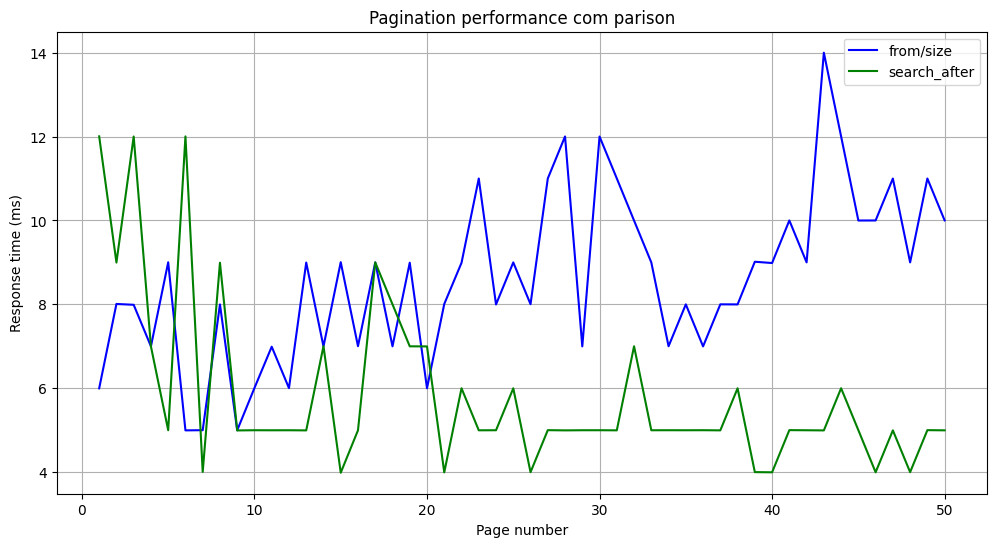

In [160]:
import matplotlib.pyplot as plt

def plot_comparition(from_size_timings, search_after_timings):
    plt.figure(figsize=(12,6))
    page_from_size, times_from_size = zip(*from_size_timings)
    page_search_size, times_search_size = zip(*search_after_timings)
    plt.plot(page_from_size, times_from_size, "b-", label='from/size')
    plt.plot(page_search_size, times_search_size, "g-", label='search_after')
    plt.xlabel("Page number")
    plt.ylabel("Response time (ms)")
    plt.title("Pagination performance com parison")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparition(from_size_timings, search_after_timings)

# 12. Ingest pipelines

In [173]:
#Create pipeline
response = es.ingest.put_pipeline(
    id= "lowercase_pipeline",
    description="This pipeline transforms the text to lowercase",
    processors=[{
        "lowercase": {
            "field": "text"
        }
    }]
)
pprint(response.body)

{'acknowledged': True}


In [174]:
# Get pipeline
response = es.ingest.get_pipeline(id='lowercase_pipeline')
pprint(response.body)

{'lowercase_pipeline': {'description': 'This pipeline transforms the text to '
                                       'lowercase',
                        'processors': [{'lowercase': {'field': 'text'}}]}}


In [175]:
# Delete a pipeline
response = es.ingest.delete_pipeline(id='lowercase_pipeline')
pprint(response.body)

{'acknowledged': True}


In [190]:
# Simulate a pipeline
response = es.ingest.put_pipeline(
    id='lowercase_pipeline',
    description='This pipeline transforms the text to lowercase',
    processors=[{
        "lowercase": {
            "field": "text_ap_dung_lowcase"
        }
    }]
)

pprint(response.body)

{'acknowledged': True}


In [183]:
response = es.ingest.simulate(
    id = 'lowercase_pipeline',
    docs=[{
        "_index":"my_index",
        "_id": "1",
        "_source":{
            "text_ap_dung_lowcase": "HELOOOOOOOOO WO"
        }}
    ]
)
pprint(response.body)

{'docs': [{'doc': {'_id': '1',
                   '_index': 'my_index',
                   '_ingest': {'timestamp': '2025-02-17T04:11:12.6571878Z'},
                   '_source': {'text_ap_dung_lowcase': 'helooooooooo wo'},
                   '_version': '-3'}}]}


In [239]:
#Load data
import json 
dummy_data = json.load(open("dummy_data.json"))
for i, document in enumerate(dummy_data):
    uppercased_text = document['text'].upper()
    document['text'] = uppercased_text
    dummy_data[i] = document

dummy_data

[{'title': 'sample title 1',
  'text': 'THIS IS THE FIRST SAMPLE DOCUMENT TEXT.',
  'created_on': '2024-09-22'},
 {'title': 'sample title 2',
  'text': 'THIS IS THE SECOND SAMPLE DOCUMENT TEXT.',
  'created_on': '2024-09-20'},
 {'title': 'sample title 3',
  'text': 'THIS IS THE THIRD SAMPLE DOCUMENT TEXT.',
  'created_on': '2024-09-10'}]

In [240]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(index='my_index')

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

In [241]:
# Use the pipeline
#Create pipeline
response = es.ingest.put_pipeline(
    id= "lowercase_pipeline",
    description="This pipeline transforms the text to lowercase",
    processors=[{
        "lowercase": {
            "field": "text"
        }
    }]
)
pprint(response.body)

operations = []
for document in dummy_data:
    operations.append({'index': {'_index': 'my_index'}})
    operations.append(document)

response = es.bulk(operations=operations, pipeline='lowercase_pipeline')
pprint(response.body)

{'acknowledged': True}
{'errors': False,
 'ingest_took': 0,
 'items': [{'index': {'_id': '7xU7EpUByzNsL-nRmzji',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '8BU7EpUByzNsL-nRmzjj',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '8RU7EpUByzNsL-nRmzjj',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '

In [242]:
hits = es.search(index='my_index').body['hits']['hits']
for hit in hits:
    pprint(hit['_source'])

{'created_on': '2024-09-22',
 'text': 'this is the first sample document text.',
 'title': 'sample title 1'}
{'created_on': '2024-09-20',
 'text': 'this is the second sample document text.',
 'title': 'sample title 2'}
{'created_on': '2024-09-10',
 'text': 'this is the third sample document text.',
 'title': 'sample title 3'}


In [243]:
# es.indices.delete(index='my_index', ignore_unavailable=True)
# es.indices.create(index='my_index')

# Handling Error
response = es.ingest.put_pipeline(
    id = 'pipeline_2',
    description='Pipeline with multiple transformations. handling and ignoring failures.',
    processors=[
        {
            "lowercase": {
                "field": "text",
                "on_failure": [{
                    "set": {
                        "field": "text",
                        "value": "FAILED TO LOWERCASE",
                        "ignore_failure": True
                    }}
                ]
            }
        },
        {
            "set": {
                "field": "new_field",
                "value": "ADDED BY PIPELINE",
                "ignore_failure": True
            }
        }
    ]
)
pprint(response.body)

{'acknowledged': True}


In [244]:
documents = [{
    'title': "Sample Title 4",
    "created_on": '2025-02-17'
    },
    {
        'title': "Sample Title 5",
        "created_on": '2025-02-17'
    }

]

for document in documents:
    response = es.index(
        index='my_index',
        pipeline='pipeline_2',
        body=document
    )

pprint(response.body)

{'_id': '8xU7EpUByzNsL-nRxjh9',
 '_index': 'my_index',
 '_primary_term': 1,
 '_seq_no': 4,
 '_shards': {'failed': 0, 'successful': 1, 'total': 2},
 '_version': 1,
 'result': 'created'}


In [245]:
hits = es.search(index='my_index', body={"query": {"match_all": {}}})['hits']['hits']
pprint([hit["_source"] for hit in hits])

[{'created_on': '2024-09-22',
  'text': 'this is the first sample document text.',
  'title': 'sample title 1'},
 {'created_on': '2024-09-20',
  'text': 'this is the second sample document text.',
  'title': 'sample title 2'},
 {'created_on': '2024-09-10',
  'text': 'this is the third sample document text.',
  'title': 'sample title 3'},
 {'created_on': '2025-02-17',
  'new_field': 'ADDED BY PIPELINE',
  'text': 'FAILED TO LOWERCASE',
  'title': 'Sample Title 4'},
 {'created_on': '2025-02-17',
  'new_field': 'ADDED BY PIPELINE',
  'text': 'FAILED TO LOWERCASE',
  'title': 'Sample Title 5'}]


In [212]:
### FAILED TO LOWERCASE -> Vì không có trường doc 4 không có trường 'text'

## 12.2 Ingest processor

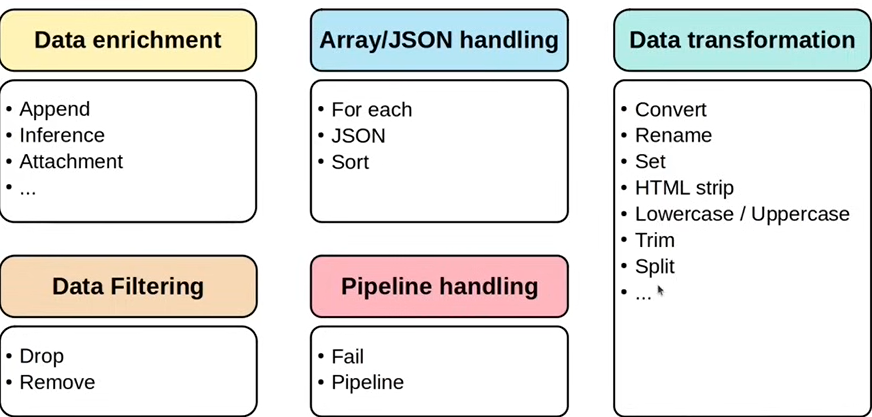

In [269]:
document = {
    "price": "100.50",
    "old_name": "old_value",
    "description": "<p>This is a description with HTMK.</p>",
    "username": "UserNAME",
    "category": "books",
    "title": "       Example Title with Whitespace          ",
    "tags": "tag1,    tag2,     tag3",
    "temporary_field": "This field should be removed"
}

In [270]:
#Create the pipeline
pipeline_body = {
    "description": "Pipeline to demonstrate various ingest processors",
    "processors": [
        {
            "convert": {
                "field": "price",
                "type": "float",
                "ignore_missing": True
            }
        },
        {
            "rename": {
                "field": "old_name",
                "target_field": "new_name"
            }
        },
        {
            "set": {
                "field": "status",
                "value": "active"
            }
        },
        {
            "html_strip": {
                "field": "description"
            }
        },
        {
            "lowercase": {
                "field": "username"
            }
        },
        {
            "uppercase": {
                "field": "category"
            }
        },
        {
            "trim": {
                "field": "title"
            }
        },
        {
            "split": {
                "field": "tags",
                "separator": ","
            }
        },
        {
            "remove":{
                "field": "temporary_field"
            }
        },
        {
            "append": {
                "field": "tags",
                "value": ['new_tag']
            }
        }
    ]
}
es.ingest.put_pipeline(id="multi_steps_pipeline", body=pipeline_body)

ObjectApiResponse({'acknowledged': True})

In [271]:
es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index="my_index")

response = es.index(index="my_index", document=document, pipeline="multi_steps_pipeline")
response.body

{'_index': 'my_index',
 '_id': '_BXDEpUByzNsL-nRmjij',
 '_version': 1,
 'result': 'created',
 '_shards': {'total': 2, 'successful': 1, 'failed': 0},
 '_seq_no': 0,
 '_primary_term': 1}

In [272]:
hits = es.search(index="my_index")['hits']['hits']
for hit in hits:
    pprint(hit['_source'])

{'category': 'BOOKS',
 'description': '\nThis is a description with HTMK.\n',
 'new_name': 'old_value',
 'price': 100.5,
 'status': 'active',
 'tags': ['tag1', '    tag2', '     tag3', 'new_tag'],
 'title': 'Example Title with Whitespace',
 'username': 'username'}


## 13. Filters in depth

In [273]:
es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index='my_index')
operations = []
clothes_documents = json.load(open("clothes.json"))
for doc in clothes_documents:
    operations.append({"index": {'_index': "my_index"}})
    operations.append(doc)

response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': '_RXWEpUByzNsL-nR_DiQ',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '_hXWEpUByzNsL-nR_DiQ',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': '_xXWEpUByzNsL-nR_DiQ',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

In [275]:
es.count(index="my_index")['count']

100

In [278]:
# Simple filters
response = es.search(
    index="my_index",
    body={
        "query": {
            "bool": {
                "filter": [
                    {
                        "term": {
                            "brand": "adidas"
                        }
                    }
                ]
            }
        },
        "size": 100
    }
)
hits = response.body['hits']['hits']
len(hits)

23

In [291]:
# Filter using an AND operation
response = es.search(
    index="my_index",
    body={
        "query": {
            "bool": {
                "filter": [
                    {
                        "term": {
                            "color": "yellow"
                        }
                    },
                    {
                        "term": {
                            'brand': "adidas"
                        }
                    }
                ]
            }
        }
    }
)

# Dùng filter thì không ảnh hưởng đến scores ranking
pprint(len(response.body['hits']['hits']))
pprint(response.body['hits']['hits'])

6
[{'_id': 'EBXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_15'}},
 {'_id': 'FxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_8'}},
 {'_id': 'GxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_21'}},
 {'_id': 'IxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_29'}},
 {'_id': 'NxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_19'}},
 {'_id': 'WxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 0.0,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_25'}}]


In [292]:
# Dùng must thì ảnh hưởng đến score ranking
response = es.search(
    index="my_index",
    body={
        "query": {
            "bool": {
                "must": [
                    {
                        "term": {
                            "color": "yellow"
                        }
                    },
                    {
                        "term": {
                            "brand": "adidas"
                        }
                    }
                ]
            }
        }
    }
)

pprint(len(response.body['hits']['hits']))
pprint(response.body['hits']['hits'])

6
[{'_id': 'EBXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_15'}},
 {'_id': 'FxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_8'}},
 {'_id': 'GxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_21'}},
 {'_id': 'IxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_29'}},
 {'_id': 'NxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_19'}},
 {'_id': 'WxXWEpUByzNsL-nR_DmQ',
  '_index': 'my_index',
  '_score': 2.9597254,
  '_source': {'brand': 'adidas', 'color': 'yellow', 'model': 'model_25'}}]


We start by narrowing our search to documents where the brand is gucci. Next, we apply aggregations to determine the document count for each color. We then define a filtered aggregation, color_red, which counts the models in documents where the color is red.

Finally, a post_filter is used after performing the aggregations, refining the search results to include only documents with the color red.


In [368]:
# POST FILTERS
response = es.search(
    index="my_index",
    body={
        "query": {
            "bool": {  ## Sử dụng truy vấn loại "bool" để kết hợp nhiều điều kiện
                "filter": {  ## Lọc các tài liệu có trường "brand" là "gucci"
                    "term": {
                        "brand": "gucci"  ## Điều kiện lọc: chỉ lấy các sản phẩm có thương hiệu "gucci"
                    }
                }
            }
        },
        'aggs': {  ## Định nghĩa các aggregation để thống kê và phân tích dữ liệu
            "colors": {  ## Tạo một aggregation để thống kê số lượng theo từng màu sắc
                "terms": {  
                    "field": "color.keyword"  ## Sử dụng trường "color.keyword" thay vì "color" để tránh lỗi phân tích từ (text analysis)
                }
            },
            "color_red": {  ## Tạo một tên aggregation "color_red" để thống kê số lượng các sản phẩm có màu "red"
                "filter": {  ## Lọc các tài liệu có màu sắc là "red"
                    "term": {  
                        "color.keyword": "red"  ## Điều kiện lọc: chỉ lấy các sản phẩm có màu "red"
                    }
                },
                "aggs": {  ## Tiến hành aggregation sau khi đã lọc
                    "models": {  ## Tạo một aggregation con để nhóm các sản phẩm màu đỏ theo model
                        "terms": {  
                            "field": "model.keyword"  ## Sử dụng trường "model.keyword" để nhóm các sản phẩm theo model
                        }
                    }
                }
            }
        },
        
        "post_filter": {
            "term": {
                "color": "red"
            }
        },
        "size": 20
    }
)

pprint(len(response.body['hits']['hits']))
pprint((response.body))


12
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'aggregations': {'color_red': {'doc_count': 12,
                                'models': {'buckets': [{'doc_count': 3,
                                                        'key': 'model_1'},
                                                       {'doc_count': 1,
                                                        'key': 'model_14'},
                                                       {'doc_count': 1,
                                                        'key': 'model_16'},
                                                       {'doc_count': 1,
                                                        'key': 'model_2'},
                                                       {'doc_count': 1,
                                                        'key': 'model_26'},
                                                       {'doc_count': 1,
                                                        'key': 'mode

In [369]:
pprint(response.body['aggregations']['colors']['buckets'])

[{'doc_count': 12, 'key': 'red'},
 {'doc_count': 8, 'key': 'blue'},
 {'doc_count': 6, 'key': 'green'},
 {'doc_count': 4, 'key': 'yellow'}]


In [370]:
pprint(response.body['aggregations']['color_red']['models']['buckets'])

[{'doc_count': 3, 'key': 'model_1'},
 {'doc_count': 1, 'key': 'model_14'},
 {'doc_count': 1, 'key': 'model_16'},
 {'doc_count': 1, 'key': 'model_2'},
 {'doc_count': 1, 'key': 'model_26'},
 {'doc_count': 1, 'key': 'model_28'},
 {'doc_count': 1, 'key': 'model_3'},
 {'doc_count': 1, 'key': 'model_4'},
 {'doc_count': 1, 'key': 'model_6'},
 {'doc_count': 1, 'key': 'model_8'}]


In [371]:
hits = response.body['hits']['hits']
for hit in hits:
    print(f"Shirt brand: {hit['_source']['brand']}, color: {hit['_source']['color']} and model: {hit['_source']['model']}")

Shirt brand: gucci, color: red and model: model_1
Shirt brand: gucci, color: red and model: model_3
Shirt brand: gucci, color: red and model: model_1
Shirt brand: gucci, color: red and model: model_4
Shirt brand: gucci, color: red and model: model_1
Shirt brand: gucci, color: red and model: model_2
Shirt brand: gucci, color: red and model: model_28
Shirt brand: gucci, color: red and model: model_6
Shirt brand: gucci, color: red and model: model_14
Shirt brand: gucci, color: red and model: model_26
Shirt brand: gucci, color: red and model: model_8
Shirt brand: gucci, color: red and model: model_16


# 14. SQL search API

In [372]:
import json

es.indices.delete(index="my_index", ignore_unavailable=True)
es.indices.create(index="my_index")

operations = []
clothes_documents = json.load(open("astronomy.json"))

for document in clothes_documents:
    operations.append({"index": {"_index": "my_index"}})
    operations.append(document)

response = es.bulk(operations=operations)
pprint(response.body)

{'errors': False,
 'items': [{'index': {'_id': 'YRUhE5UByzNsL-nRWznU',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'YhUhE5UByzNsL-nRWznU',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'YxUhE5UByzNsL-nRWznU',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

In [384]:
# Select querry SQL seach API
query = {
    "query": "SELECT title FROM my_index ORDER BY id DESC LIMIT 5"
}

response = es.sql.query(body=query)
pprint(response)
for row in response['rows']:
    print(row)

ObjectApiResponse({'columns': [{'name': 'title', 'type': 'text'}], 'rows': [['Space Exploration'], ['The Expanding Universe'], ['Dark Matter'], ['Astrobiology'], ['The Life Cycle of Stars']]})
['Space Exploration']
['The Expanding Universe']
['Dark Matter']
['Astrobiology']
['The Life Cycle of Stars']


In [394]:
# Change respine format
query = {
    "query": "SELECT * FROM my_index"}

pprint(es.sql.query(body=query, format = 'txt').body)

('                                                                                                        '
 'content                                                                                                         '
 '|      id       |         title         \n'
 '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+-----------------------\n'
 'The Solar System consists of the Sun and the objects that orbit it, '
 'including eight planets, their moons, dwarf planets, and countless small '
 'bodies like asteroids and comets.                                          '
 '|1              |The Solar System       \n'
 'A black hole is a region of space where the gravitational pull is so strong '
 'that nothing, not even light, can escape from it. They are formed when '
 'massive stars collapse under their ow